In [1]:
from skimage.io import imread
import cv2
from skimage.transform import resize
import numpy as np
import torch
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import yaml

In [2]:
config_path = '../config/params.yml'
config = yaml.load(open(config_path), Loader=yaml.FullLoader)

# Тестирование модели
Составление общего пайплайна предсказания модели и тестирование его на изображении 

In [10]:
size = config['train']['size']
model_weights_path = config['train']['deeplab_bce_weights_path']

In [11]:
def mask_of_image_pipeline(im_path: str, size: list[int] = size,
                           model_weights_path: str = model_weights_path
) -> torch.Tensor:
    """
    Основной пайплайн нахождения маски по изображению дорог
    :params im_path: путь до изображения
    :params size: разрешение изображения, к которому нужно его привести
    :params model_weights_path: путь до сохраненных весов предобученной модели
                                deeplab
    :return: тензор маски изображения
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    im = imread(im_path)
    im = resize(cv2.cvtColor(im, cv2.COLOR_BGRA2BGR),
                size, mode='constant', anti_aliasing=True)
    im = np.array(im, np.float32)
    im = np.rollaxis(im, 2, 0)
    im = im.reshape((1, 3, size[0], size[1]))
    im = torch.Tensor(im).to(device)

    deeplab_model = smp.DeepLabV3Plus(
        encoder_name='resnet101',
        encoder_weights='imagenet',
        classes=1,
        activation=None
    ).to(device)
    deeplab_model.load_state_dict(torch.load(model_weights_path))

    deeplab_model.eval()
    with torch.no_grad():
        out = deeplab_model(im)
        out = (out.to('cpu') > 0.5).type(torch.long).detach().numpy()

    return out

In [12]:
screen_path = config['eval']['eval_image_path']

In [3]:
def im_show(im: torch.Tensor) -> None:
    """
    Отрисовка изображения
    :params im: тензор изображения
    """
    plt.imshow(im[0, 0], cmap='gray')

In [14]:
mask = mask_of_image_pipeline(screen_path)

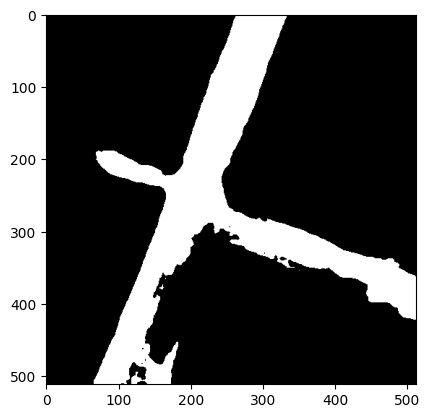

In [15]:
im_show(mask)